# Coordinate Ascent Variational Inference (CAVI) Implementation for the Gaussian Mixture Model (GMM)

In this notebook there is a simple implementation of Variational Inference using Python and the `numpy` library.

We will implement the CAVI algorithm (with the updates obtained in the `README.md` section) to fit the proposed Gaussian Mixture Model (GMM).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs 
import seaborn as sns 

First, we will generate synthetic data using the `make_blobs` function from the `sklearn.datasets` module. This will allow us to create a dataset with 4 clusters with unitarian standard deviation, which we will then use to fit our GMM.

```python

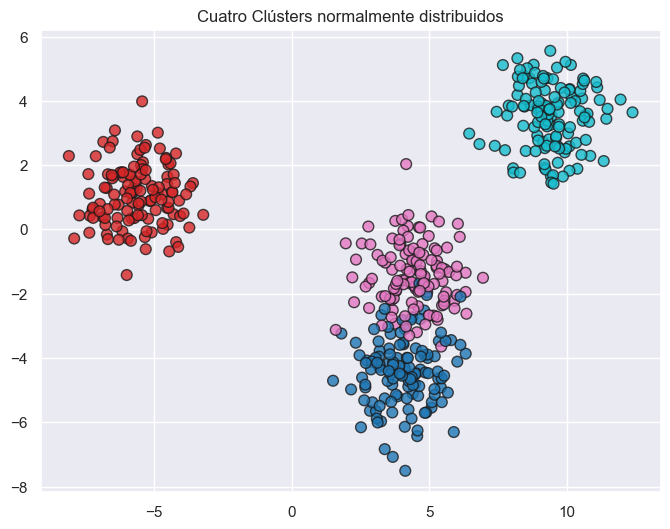

In [2]:
np.random.seed(123) # Seed for reproducibility

# Generate synthetic data with 4 clusters using make_blobs from scikitk-learn
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std= 1, shuffle= True)

# Plot the generated data
sns.set(style = "darkgrid", context = "notebook")
fig, ax = plt.subplots(figsize = (8,6))
scatter = ax.scatter(X[:,0], X[:, 1], c = y, cmap='tab10', edgecolor = 'k', s = 60, alpha = 0.8)
ax.set_title("Cuatro Clústers normalmente distribuidos")

plt.show()

We can observe how the data is well defined and separated into 4 clusters, which will be useful for our GMM fitting.

In [3]:
X[0:4,:]

array([[ 4.80324248, -1.49052892],
       [ 9.38585734,  3.24692717],
       [ 5.28029615, -0.98091826],
       [-5.30151457, -0.61310159]])

In [4]:
y

array([2, 3, 2, 1, 3, 1, 3, 3, 0, 0, 0, 1, 3, 1, 1, 1, 3, 3, 2, 3, 3, 2,
       1, 2, 3, 0, 1, 2, 1, 0, 2, 1, 2, 2, 0, 3, 2, 0, 2, 1, 0, 2, 0, 2,
       3, 0, 0, 3, 1, 1, 0, 3, 2, 2, 0, 0, 0, 1, 1, 3, 0, 0, 3, 0, 2, 0,
       3, 1, 0, 2, 3, 0, 2, 2, 3, 2, 2, 1, 3, 2, 1, 1, 1, 3, 2, 3, 1, 1,
       0, 3, 2, 0, 1, 2, 1, 1, 2, 1, 1, 3, 2, 3, 1, 2, 2, 2, 3, 0, 3, 2,
       2, 2, 1, 3, 3, 1, 0, 3, 3, 1, 2, 2, 3, 3, 2, 3, 3, 0, 3, 0, 2, 1,
       2, 3, 1, 1, 0, 1, 0, 1, 0, 0, 3, 0, 2, 0, 2, 3, 0, 2, 3, 2, 3, 2,
       3, 0, 0, 0, 2, 3, 3, 0, 2, 1, 0, 3, 2, 1, 2, 0, 1, 2, 3, 2, 2, 1,
       1, 1, 2, 3, 2, 1, 3, 3, 3, 0, 1, 0, 2, 1, 1, 0, 1, 3, 3, 3, 2, 0,
       1, 1, 3, 1, 3, 0, 3, 3, 2, 0, 0, 0, 0, 3, 3, 0, 3, 2, 1, 2, 3, 1,
       3, 0, 0, 3, 1, 1, 1, 3, 0, 2, 2, 0, 1, 1, 3, 1, 0, 3, 0, 1, 2, 2,
       1, 0, 0, 0, 3, 2, 3, 2, 3, 0, 0, 3, 1, 1, 3, 0, 2, 1, 3, 1, 1, 1,
       3, 3, 1, 0, 0, 1, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 0, 0, 0, 3, 0, 3,
       0, 0, 0, 3, 1, 2, 1, 3, 3, 0, 0, 1, 2, 1, 2,

Now, we will randomly initialize the parameters of our GMM. This includes the means, covariances, and mixing coefficients for each of the 4 clusters. 

In [5]:
def initialize_parameters(n_samples,n_centers):
  """
  Initializes the model parameters given the sample size and the number of clusters.

  Parameters
  ----------
  n_samples: int
    Sample size.

  n_centers: int
    Number of clusters.

  Returns
  --------
  m: numpy.array
    Matrix formed by the variational mean vectors.

  s2: numpy.array
    Vector of variational variances for each cluster.

  phi: numpy.array
    Variational phi vector of probabilities.
  """
  n = n_samples
  k = n_centers

  m = np.random.randn(k,2)*2
  s2 = np.ones(k)*10 #son varianzas
  phi = np.ones((n,k))*1/k

  return m, s2, phi

Given the parameters of the GMM, we can define the ELBO (Evidence Lower Bound) function, which will be used to evaluate the quality of our variational approximation. 

In [6]:
def compute_elbo(X, m, s2, phi, sigma2):
  """
  Computes the ELBO of the model.

  Parameters
  ----------
  X: numpy.array
    Input data matrix (n_samples, n_features).

  m: numpy.array
    Matrix of variational means.

  s2: numpy.array
    Vector of variational variances.

  phi: numpy.array
    Variational phi matrix with responsibilities.

  sigma2: float
    Variance of the generative model.

  Returns
  -------
  elbo: float
    The value of the ELBO bound.
  """
  n,k = phi.shape

  term1 = - k * np.log(2*np.pi*sigma2) - 1/(2*sigma2)*(np.sum(m**2) + 2*np.sum(s2))
  term2 = -n*np.log(k)


  term3 = 0
  for i in range(n):
      for j in range(k):
          diff = X[i] - m[j]
          term3 += phi[i, j] * (-0.5 * np.log(2 * np.pi) - 0.5 * np.sum(diff**2) - s2[j])

  term4 = -np.sum(phi*np.log(phi))
  term5 = -np.sum(np.log(2*np.pi*np.e*s2))

  elbo = term1 + term2 + term3 + term4 + term5

  return elbo

And then, following the calculations in the `README.md` section, we will implement the updates for the parameters of the GMM and ultimately the complete CAVI algorithm. 

In [7]:
def update_phi(X,m,s2,phi):
    """
    Updates the phi matrix of variational responsibilities.

    Parameters
    ----------
    X: numpy.array
      Input data (n_samples x n_features).

    m: numpy.array
      Current variational means.

    s2: numpy.array
      Current variational variances.

    phi: numpy.array
      Current responsibility matrix.

    Returns
    -------
    phi: numpy.array
      Updated responsibility matrix.
    """
    n, d = X.shape
    k = m.shape[0]
    phi = np.zeros((n, k))

    for i in range(n):
        for j in range(k):
            diff = X[i,:] - m[j,:]                      # (d,)
            sq_norm = np.dot(diff, diff)           # ||x_i - m_k||^2
            var_term = s2[j]               # s_{k}^2
            phi[i, j] = np.exp(-0.5 * sq_norm - 0.5 * var_term)

        # Normalizar
        phi[i, :] /= np.sum(phi[i, :])

    return phi

In [8]:
def update_centers(X,phi,sigma2,m,s2):
  """
  Updates the variational means m and variances s2 of the model.

  Parameters
  ----------
  X: numpy.array
    Input data (n_samples x n_features).

  phi: numpy.array
    Matrix of variational responsibilities.

  sigma2: float
    Variance of the generative model.

  m: numpy.array
    Current means.

  s2: numpy.array
    Current variances.

  Returns
  -------
  m: numpy.array
    Updated means.

  s2: numpy.array
    Updated variances.
  """
  n = X.shape[1]
  k = m.shape[0]

  for j in range(k):
    m[j,:] = np.dot(phi[:, j], X)/(1/sigma2 + np.sum(phi[:,j]))
    s2[j] = 1/(1/sigma2 + np.sum(phi[:,j]))

  return m,s2

In [9]:
def cavi(X,n_centers,sigma2, max_iter = 50, plot_start = True):
  """
  Runs the CAVI (Coordinate Ascent Variational Inference) algorithm.

  Parameters
  ----------
  X: numpy.array
    Input data (n_samples x n_features).

  n_centers: int
    Number of clusters.

  sigma2: float
    Variance of the generative model.

  max_iter: int
    Maximum number of iterations.

  plot_start: bool
    If True, it shows a plot with the initial centers. Default: True.

  Returns
  -------
  phi: numpy.array
    Matrix of variational responsibilities.

  m: numpy.array
    Learned variational means.

  s2: numpy.array
    Learned variational variances.

  elbo_values: list
    ELBO values during the iterations.
  """
  n = X.shape[0]
  k = n_centers

  m, s2 , phi = initialize_parameters(n,k)

  if plot_start:
    fig, ax = plt.subplots(figsize = (8,6))
    scatter = ax.scatter(X[:,0], X[:, 1], c = y, cmap='tab10', edgecolor = 'k', s = 60, alpha = 0.8)
    scatter = ax.scatter(m[:,0], m[:,1], c = 'yellow', edgecolor = 'k', s = 100, alpha = 1)
    plt.savefig("inicio.pdf", format="pdf", dpi=300)
    plt.show()
    print("MONITOREO DEL ELBO")

  elbo_values = []
  elbo_values.append(compute_elbo(X, m, s2, phi, sigma2))

  for i in range(max_iter):
    phi = update_phi(X,m,s2,phi)
    m, s2 = update_centers(X,phi,sigma2,m,s2)
    elbo_values.append(compute_elbo(X , m , s2, phi, sigma2))

    if i % 5 == 0 and plot_start:
      print(f"Valor del ELBO en la iteración {i}: {elbo_values[-1]}")  #Control del ELBO

  return phi, m, s2, elbo_values

Now, we can apply the CAVI algorithm to our synthetic data and observe how the parameters of the GMM converge to fit the data well. 

Finally, we can visualize the results of our GMM fitting, showing the estimated means, covariances, and mixing coefficients for each cluster. This will allow us to see how well our GMM has captured the underlying structure of the data.

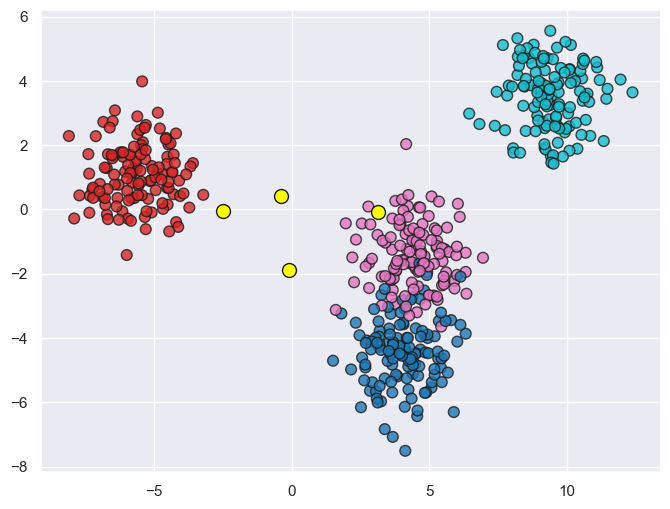

MONITOREO DEL ELBO
Valor del ELBO en la iteración 0: -4212.401212118804
Valor del ELBO en la iteración 5: -1703.6445554014165
Valor del ELBO en la iteración 10: -1703.064483580765
Valor del ELBO en la iteración 15: -1703.0643912509088
Valor del ELBO en la iteración 20: -1703.0643916094741
Valor del ELBO en la iteración 25: -1703.064391614956
Valor del ELBO en la iteración 30: -1703.0643916150354
Valor del ELBO en la iteración 35: -1703.0643916150366
Valor del ELBO en la iteración 40: -1703.0643916150377
Valor del ELBO en la iteración 45: -1703.0643916150375


In [10]:
phi, m, s2, elbo_values = cavi(X, n_centers=4, sigma2=1, max_iter=50)

The ELBO can be monitored during the iterations to ensure that the algorithm is converging. We can plot the ELBO values over iterations for 10 different initializations to visualize the convergence behavior, which is indeed very fast for this simple GMM example and also shows that the ELBO is a non-convex function, as expected in variational inference.

C:\Users\Ángel\AppData\Local\Temp\ipykernel_17244\403844983.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


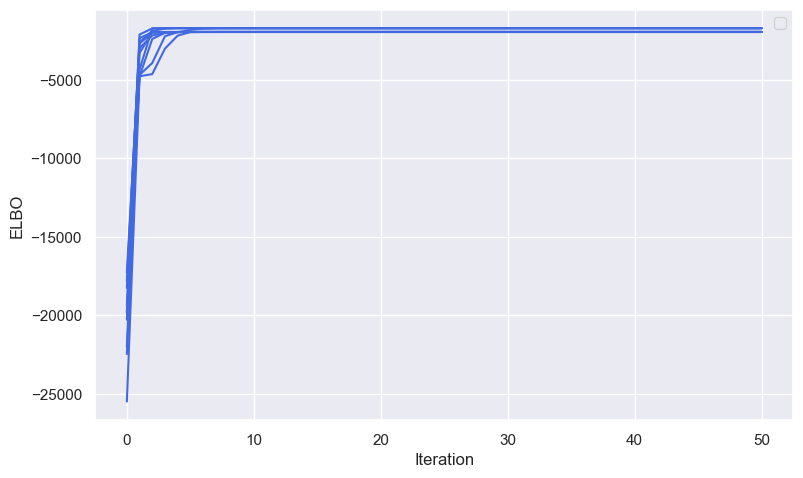

In [11]:
#monitoreo del ELBO
plt.figure(figsize=(8, 5))
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.grid(True)
plt.legend()
plt.tight_layout()

elbos = np.zeros((10, 51))


for i in range(elbos.shape[0]):
  _,_,_, elbo_values = cavi(X, n_centers=4, sigma2=1, max_iter=50, plot_start=False)
  plt.plot(elbo_values, label="ELBO", color='royalblue')

plt.savefig("elbo.pdf", format = 'pdf', dpi = 300)
plt.show()

We can observe the variational parameters values after running the CAVI algorithm. The estimated means of the clusters are very close to the true cluster centroids, and the variances converge to very small values, indicating high confidence in the estimated cluster means. The cluster assignments probabilities for each data point correctly assign it to a single cluster with very high probability close to 1 for datapoints at the true centroid.

In [12]:
phi[9,:]

array([3.55072679e-26, 9.99931652e-01, 1.12758419e-31, 6.83484881e-05])

In [13]:
s2

array([0.00793655, 0.00806809, 0.00793651, 0.0078091 ])

In [14]:
y[9]

np.int64(0)

In [15]:
m[0,:]

array([9.34662471, 3.49039364])

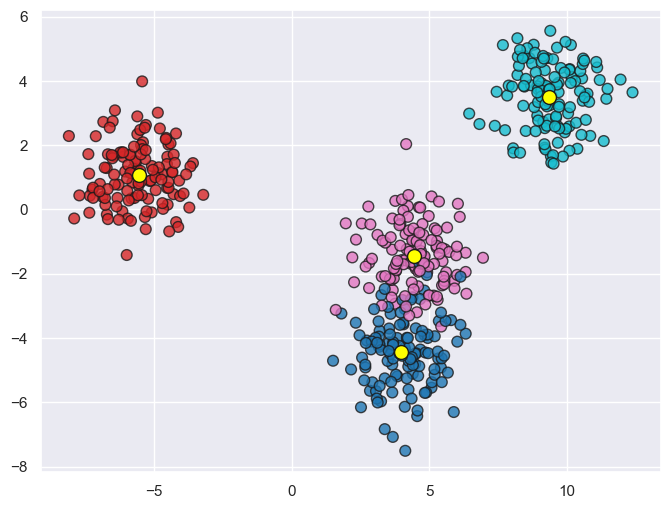

In [17]:
fig, ax = plt.subplots(figsize = (8,6))
scatter = ax.scatter(X[:,0], X[:, 1], c = y, cmap='tab10', edgecolor = 'k', s = 60, alpha = 0.8)
scatter = ax.scatter(m[:,0], m[:,1], c = 'yellow', edgecolor = 'k', s = 100, alpha = 1)
plt.savefig("final.pdf", format = 'pdf', dpi = 300)
plt.show()